# Implementation of the model that infers the number of lines depicted on the line graph images
This approach involves cutting the image of the legends and inferring the number of lines from it, through the vgg16 model

IMPORTARE IL DATASET CON LE ANNOTAZIONI

In [ ]:
!unzip ds.zip

!rm ds.zip

!mkdir output
!mkdir output/Plots

CONFIG FILE

In [ ]:
# import the necessary packages
import os
MAX_NUM_LINES = 10
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "legend_dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "Annotated_images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations.csv"])

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Plots/"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
TRAIN_FILENAMES = os.path.sep.join([BASE_OUTPUT, "train_images.txt"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32

# min height legende = 18
# min width legende = 46
# max size legede: (h=338, w=896)

VGG_HEIGHT = VGG_WIDTH = 224
MIN_HEIGHT = 224
MIN_WIDTH = 224

MODEL FILE

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Flatten, AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from eiou_loss import EIoULoss
from tensorflow.keras.losses import MeanAbsoluteError, CategoricalCrossentropy, MeanSquaredLogarithmicError
from tensorflow.keras.metrics import Accuracy
# import config
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential


def get_model():
    # load the VGG16 network, ensuring the head FC layers are left off
    input = Input(shape=(224, 224, 3))

    vgg = VGG16(weights="imagenet", include_top=False)
    print("STRUTTURA VGG16")
    for layer in vgg.layers[:-4]:
        layer.trainable = False
    vgg.summary()

    x = vgg(input)
    x = Flatten(input_shape=(7, 7, 512))(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x)

    # construct a fully-connected layer header to output the predicted
    # bounding box coordinates

    # legend_output = Flatten(input_shape=(7, 7, 512))(x)
    # legend_output = Dense(256, activation='relu')(legend_output)
    # legend_output = Dropout(0.2)(x)
    # legend_output = Dense(4, activation='sigmoid', name='legend_bbox')(legend_output)

    # axis_output = Flatten(input_shape=(7, 7, 512))(x)
    # axis_output = Dense(256, activation='relu')(axis_output)
    # axis_output = Dropout(0.2)(x)
    # axis_output = Dense(4, activation='linear', name='axis_bbox')(axis_output)

    # categorical_output = Flatten(input_shape=(7, 7, 512))(x)
    # categorical_output = Dense(256, activation='relu')(categorical_output)
    categorical_output = Dropout(0.3)(x)
    categorical_output = Dense(1, activation='linear', name='num_lines')(categorical_output)

    model = Model(input, categorical_output)

    # initialize the optimizer, compile the model, and show the model
    # summary
    opt = Adam()
    model.compile(loss=MeanAbsoluteError(), optimizer=opt)
    print("STRUTTURA MODELLO COMPLETO")
    model.summary()
    plot_model(model, to_file=BASE_OUTPUT + '/model.png')

    return model


def get_my_model():
  # load the VGG16 network, ensuring the head FC layers are left off
  input = Input(shape=(MIN_HEIGHT, MIN_WIDTH, 3))

  x = Conv2D(16, (2, 2), input_shape=(MIN_HEIGHT, MIN_WIDTH, 3))(input)
  x = MaxPooling2D()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(32, (2, 2))(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, (2, 2))(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)

  categorical_output = Dropout(0.3)(x)
  categorical_output = Dense(32, activation='relu')(categorical_output)
  categorical_output = Dropout(0.3)(categorical_output)
  categorical_output = Dense(1, activation='linear', name='num_lines')(categorical_output)

  model = Model(input, categorical_output)

  # initialize the optimizer, compile the model, and show the model
  # summary
  opt = Adam()
  model.compile(loss=MeanAbsoluteError(), optimizer=opt)
  print("STRUTTURA MODELLO COMPLETO")
  model.summary()
  plot_model(model, to_file=BASE_OUTPUT + '/model.png')

  return model

TRAIN FILE

In [ ]:
def save_plot(plot_name, H, parameters, title, loss_plot=True):
    N = NUM_EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    for parameter in parameters:
        plt.plot(np.arange(0, N), H.history[parameter], label=parameter)
    plt.title('\n'.join(wrap(title, 60)))
    plt.xlabel("Epoch #")
    if loss_plot:
        plt.legend(loc="upper right")
        plt.ylabel("Loss")
    else:
        plt.legend(loc="lower left")
        plt.ylabel("Accuracy")
    plt.savefig(PLOT_PATH + plot_name)

In [ ]:
# import the necessary packages
#from config import *

# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
# from my_model import *
from textwrap import wrap

# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
axis_targets = []
num_lines_targets = []
filenames = []

# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY, a_startX, a_startY, a_endX, a_endY, num_lines) = row

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    a_startX = float(a_startX) / w
    a_startY = float(a_startY) / h
    a_endX = float(a_endX) / w
    a_endY = float(a_endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(MIN_HEIGHT, MIN_WIDTH))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    axis_targets.append((a_startX, a_startY, a_endX, a_endY))
    # array = [0] * MAX_NUM_LINES
    # array[int(num_lines) - 1] = 1
    num_lines_targets.append(int(num_lines))
    filenames.append(filename)

# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
axis_targets = np.array(axis_targets, dtype="float32")
num_lines_targets = np.array(num_lines_targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, axis_targets, num_lines_targets, filenames, test_size=0.20,
                         random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(train_axis_Targets, test_axis_Targets) = split[4:6]
(train_num_lines_Targets, test_num_lines_Targets) = split[6:8]
(trainFilenames, testFilenames) = split[8:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

print("[INFO] saving training filenames...")
f = open(TRAIN_FILENAMES, "w")
f.write("\n".join(trainFilenames))
f.close()

# for image, target, a_target, nl_target in zip(trainImages, trainTargets, train_axis_Targets, train_num_lines_Targets):
#     print(image, target, a_target)
#     break

model = get_model()

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, train_num_lines_Targets,
    validation_data=(testImages, test_num_lines_Targets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history

[INFO] loading dataset...
[INFO] saving testing filenames...
[INFO] saving training filenames...
STRUTTURA VGG16
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________

Disegna i grafici

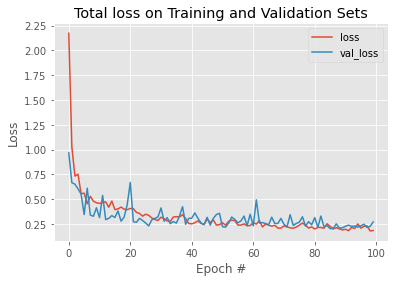

In [ ]:
save_plot('total_loss.png', H, ['loss', 'val_loss'], 'Total loss on Training and Validation Sets')
# save_plot('legend_loss.png', H, ['legend_bbox_loss', 'val_legend_bbox_loss'], 'Legend MAE loss on Training and Validation Sets')
# save_plot('axis_loss.png', H, ['axis_bbox_loss', 'val_axis_bbox_loss'], 'Axis MAE loss on Training and Validation Sets')
# save_plot('num_lines_loss.png', H, ['num_lines_loss', 'val_num_lines_loss'], 'num_lines MAE loss on Training and Validation Sets')

# save_plot('legend_mae.png', H, ['legend_bbox_mae', 'val_legend_bbox_mae'], 'Legend MAE loss on Training and Validation Sets')
# save_plot('axis_mae.png', H, ['axis_bbox_mae', 'val_axis_bbox_mae'], 'Axis MAE loss on Training and Validation Sets')
# save_plot('num_lines_mae.png', H, ['num_lines_mae', 'val_num_lines_mae'], 'num_lines MAE loss on Training and Validation Sets')

# save_plot('num_lines_accuracy.png', H, ['num_lines_accuracy', 'val_num_lines_accuracy'], 'Accuracy of num lines prediction on Test and Validation sets', loss_plot=False)

PREDICT FILE

predire su training (1) o su validation (2)?: 2
[INFO] loading object detector...
legend_dataset/Annotated_images/00490-10.1.1.18.7410-Figure-1.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


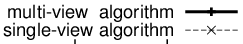

legend_dataset/Annotated_images/01493-10.1.1.132.2653-Figure-11.png
numero di linee attuale: 3
risultato originale predetto: 2.7998123
numero di linee predetto dell'immagine: 3


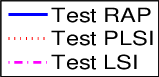

legend_dataset/Annotated_images/00079-10.1.1.149.7852-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.4586098
numero di linee predetto dell'immagine: 2


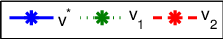

legend_dataset/Annotated_images/00178-10.1.1.39.8052-Figure-6.png
numero di linee attuale: 4
risultato originale predetto: 4.1534557
numero di linee predetto dell'immagine: 4


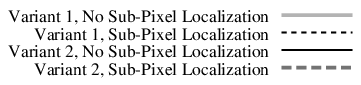

legend_dataset/Annotated_images/02662-10.1.1.367.8234-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 2.001147
numero di linee predetto dell'immagine: 2


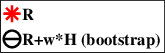

legend_dataset/Annotated_images/03180-10.1.1.14.3650-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 2.0228953
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/01217-10.1.1.170.2394-Figure-3.png
numero di linee attuale: 5
risultato originale predetto: 4.556607
numero di linee predetto dell'immagine: 5


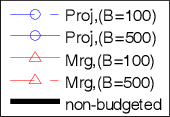

legend_dataset/Annotated_images/00286-10.1.1.225.6195-Figure-4.png
numero di linee attuale: 5
risultato originale predetto: 3.994801
numero di linee predetto dell'immagine: 4


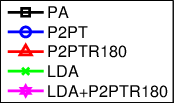

legend_dataset/Annotated_images/01024-10.1.1.408.772-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


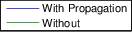

legend_dataset/Annotated_images/00916-10.1.1.368.1401-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


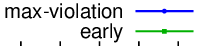

legend_dataset/Annotated_images/00161-10.1.1.37.1152-Figure-12.png
numero di linee attuale: 4
risultato originale predetto: 3.7788024
numero di linee predetto dell'immagine: 4


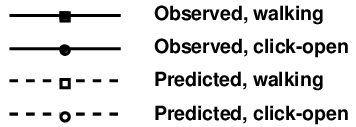

legend_dataset/Annotated_images/02126-10.1.1.385.5289-Figure-7.png
numero di linee attuale: 3
risultato originale predetto: 2.9538007
numero di linee predetto dell'immagine: 3


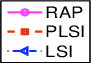

legend_dataset/Annotated_images/03064-10.1.1.318.2358-Figure-6.png
numero di linee attuale: 4
risultato originale predetto: 4.196591
numero di linee predetto dell'immagine: 4


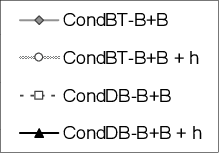

legend_dataset/Annotated_images/02534-10.1.1.393.71-Figure-3.png
numero di linee attuale: 5
risultato originale predetto: 4.344241
numero di linee predetto dell'immagine: 4


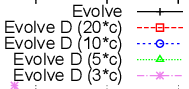

legend_dataset/Annotated_images/01883-10.1.1.36.1710-Figure-14.png
numero di linee attuale: 3
risultato originale predetto: 2.860569
numero di linee predetto dell'immagine: 3


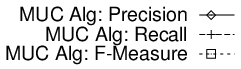

legend_dataset/Annotated_images/00749-10.1.1.208.3744-Figure-5.png
numero di linee attuale: 5
risultato originale predetto: 4.758686
numero di linee predetto dell'immagine: 5


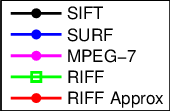

legend_dataset/Annotated_images/02460-10.1.1.15.3331-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 2.2031965
numero di linee predetto dell'immagine: 2


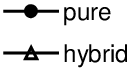

legend_dataset/Annotated_images/03119-10.1.1.228.6129-Figure-6.png
numero di linee attuale: 3
risultato originale predetto: 2.5917225
numero di linee predetto dell'immagine: 3


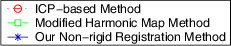

legend_dataset/Annotated_images/00589-10.1.1.172.7415-Figure-3.png
numero di linee attuale: 3
risultato originale predetto: 2.66605
numero di linee predetto dell'immagine: 3


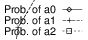

legend_dataset/Annotated_images/02347-10.1.1.397.4173-Figure-1.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


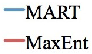

legend_dataset/Annotated_images/01053-10.1.1.132.396-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


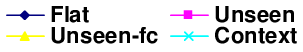

legend_dataset/Annotated_images/00861-10.1.1.152.6073-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 3.7561555
numero di linee predetto dell'immagine: 4


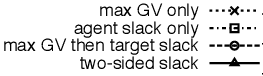

legend_dataset/Annotated_images/00106-10.1.1.50.6953-Figure-10.png
numero di linee attuale: 3
risultato originale predetto: 2.6317048
numero di linee predetto dell'immagine: 3


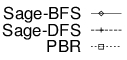

legend_dataset/Annotated_images/02614-10.1.1.231.6389-Figure-9.png
numero di linee attuale: 5
risultato originale predetto: 5.335871
numero di linee predetto dell'immagine: 5


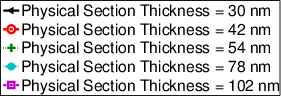

legend_dataset/Annotated_images/01244-10.1.1.46.8532-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.875772
numero di linee predetto dell'immagine: 4


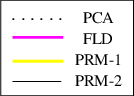

legend_dataset/Annotated_images/02748-10.1.1.187.6294-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 3.0997279
numero di linee predetto dell'immagine: 3


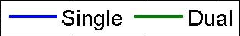

legend_dataset/Annotated_images/01230-10.1.1.24.7632-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


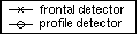

legend_dataset/Annotated_images/02972-10.1.1.408.504-Figure-8.png
numero di linee attuale: 5
risultato originale predetto: 5.0421333
numero di linee predetto dell'immagine: 5


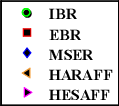

legend_dataset/Annotated_images/00725-10.1.1.218.202-Figure-4.png
numero di linee attuale: 6
risultato originale predetto: 3.049954
numero di linee predetto dell'immagine: 3


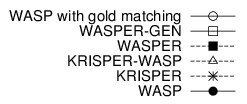

legend_dataset/Annotated_images/02850-10.1.1.421.2931-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


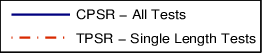

legend_dataset/Annotated_images/02624-10.1.1.167.3821-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


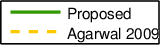

legend_dataset/Annotated_images/01318-10.1.1.314.9616-Figure-6.png
numero di linee attuale: 3
risultato originale predetto: 2.639207
numero di linee predetto dell'immagine: 3


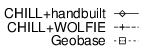

legend_dataset/Annotated_images/02191-10.1.1.107.1966-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.7427397
numero di linee predetto dell'immagine: 3


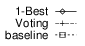

legend_dataset/Annotated_images/00904-10.1.1.167.5438-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.524456
numero di linee predetto dell'immagine: 4


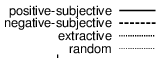

legend_dataset/Annotated_images/03155-10.1.1.150.8670-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 4.052601
numero di linee predetto dell'immagine: 4


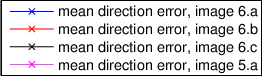

legend_dataset/Annotated_images/02687-10.1.1.320.1735-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.5527024
numero di linee predetto dell'immagine: 4


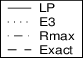

legend_dataset/Annotated_images/01246-10.1.1.224.9900-Figure-12.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


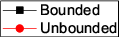

legend_dataset/Annotated_images/01160-10.1.1.205.9731-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.982833
numero di linee predetto dell'immagine: 4


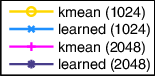

legend_dataset/Annotated_images/01765-10.1.1.117.6081-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.8218498
numero di linee predetto dell'immagine: 3


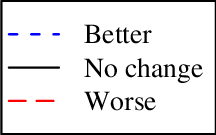

legend_dataset/Annotated_images/00258-10.1.1.39.8052-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.7909915
numero di linee predetto dell'immagine: 4


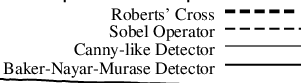

legend_dataset/Annotated_images/00612-10.1.1.117.6081-Figure-1.png
numero di linee attuale: 3
risultato originale predetto: 2.76872
numero di linee predetto dell'immagine: 3


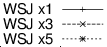

legend_dataset/Annotated_images/02600-10.1.1.394.1549-Figure-7.png
numero di linee attuale: 9
risultato originale predetto: 4.4133005
numero di linee predetto dell'immagine: 4


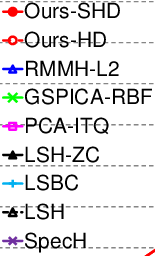

legend_dataset/Annotated_images/00819-10.1.1.208.7348-Figure-6.png
numero di linee attuale: 5
risultato originale predetto: 5.128541
numero di linee predetto dell'immagine: 5


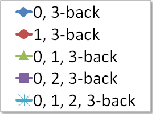

legend_dataset/Annotated_images/00685-10.1.1.308.144-Figure-4.png
numero di linee attuale: 10
risultato originale predetto: 5.256332
numero di linee predetto dell'immagine: 5


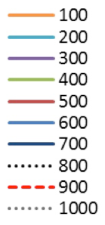

legend_dataset/Annotated_images/03108-10.1.1.401.2455-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 3.1569862
numero di linee predetto dell'immagine: 3


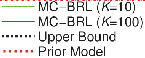

legend_dataset/Annotated_images/01063-10.1.1.421.5324-Figure-1.png
numero di linee attuale: 3
risultato originale predetto: 3.1048741
numero di linee predetto dell'immagine: 3


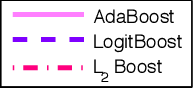

legend_dataset/Annotated_images/00650-10.1.1.366.1909-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 3.1681397
numero di linee predetto dell'immagine: 3


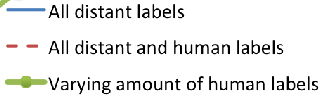

legend_dataset/Annotated_images/02997-10.1.1.42.3255-Figure-7.png
numero di linee attuale: 4
risultato originale predetto: 4.026047
numero di linee predetto dell'immagine: 4


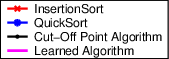

legend_dataset/Annotated_images/02618-10.1.1.140.9693-Figure-2.png
numero di linee attuale: 5
risultato originale predetto: 5.433103
numero di linee predetto dell'immagine: 5


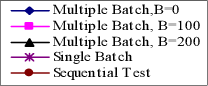

legend_dataset/Annotated_images/00069-10.1.1.29.3097-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 2.8748543
numero di linee predetto dell'immagine: 3


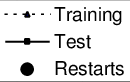

legend_dataset/Annotated_images/01043-10.1.1.298.189-Figure-2.png
numero di linee attuale: 6
risultato originale predetto: 6.198264
numero di linee predetto dell'immagine: 6


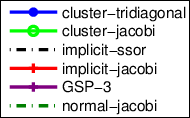

legend_dataset/Annotated_images/01020-10.1.1.112.6853-Figure-7.png
numero di linee attuale: 4
risultato originale predetto: 3.0253112
numero di linee predetto dell'immagine: 3


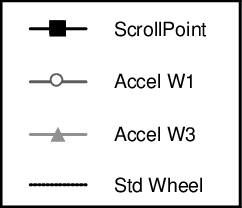

legend_dataset/Annotated_images/02777-10.1.1.348.4141-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 2.0064523
numero di linee predetto dell'immagine: 2


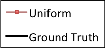

legend_dataset/Annotated_images/02842-10.1.1.306.7483-Figure-7.png
numero di linee attuale: 7
risultato originale predetto: 8.709907
numero di linee predetto dell'immagine: 9


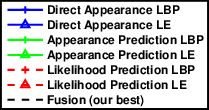

legend_dataset/Annotated_images/00817-10.1.1.107.8456-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 2.3765843
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/01058-10.1.1.208.4085-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.8180444
numero di linee predetto dell'immagine: 4


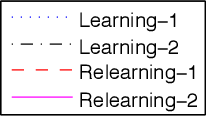

legend_dataset/Annotated_images/00232-10.1.1.190.9949-Figure-5.png
numero di linee attuale: 3
risultato originale predetto: 2.8492665
numero di linee predetto dell'immagine: 3


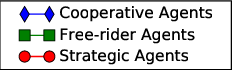

legend_dataset/Annotated_images/00183-10.1.1.107.7761-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


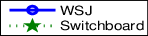

legend_dataset/Annotated_images/02712-10.1.1.149.7852-Figure-4.png
numero di linee attuale: 5
risultato originale predetto: 2.1654704
numero di linee predetto dell'immagine: 2


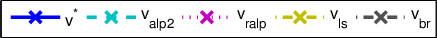

legend_dataset/Annotated_images/02164-10.1.1.218.85-Figure-13.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


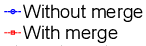

legend_dataset/Annotated_images/00674-10.1.1.164.3655-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/01904-10.1.1.113.6022-Figure-2.png
numero di linee attuale: 8
risultato originale predetto: 3.950282
numero di linee predetto dell'immagine: 4


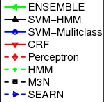

legend_dataset/Annotated_images/01938-10.1.1.378.5484-Figure-1.png
numero di linee attuale: 3
risultato originale predetto: 2.9373937
numero di linee predetto dell'immagine: 3


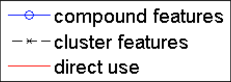

legend_dataset/Annotated_images/02421-10.1.1.4.133-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.9436417
numero di linee predetto dell'immagine: 2


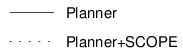

legend_dataset/Annotated_images/02118-10.1.1.113.4764-Figure-2.png
numero di linee attuale: 6
risultato originale predetto: 6.4364686
numero di linee predetto dell'immagine: 6


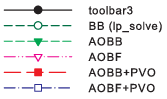

legend_dataset/Annotated_images/01681-10.1.1.164.3678-Figure-8.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/03334-10.1.1.153.7148-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.8315254
numero di linee predetto dell'immagine: 2


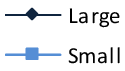

legend_dataset/Annotated_images/02676-10.1.1.301.3656-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.8473792
numero di linee predetto dell'immagine: 3


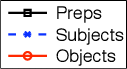

legend_dataset/Annotated_images/00649-10.1.1.408.9944-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.8707395
numero di linee predetto dell'immagine: 4


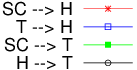

legend_dataset/Annotated_images/00835-10.1.1.2.9380-Figure-10.png
numero di linee attuale: 4
risultato originale predetto: 4.016158
numero di linee predetto dell'immagine: 4


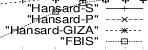

legend_dataset/Annotated_images/01016-10.1.1.51.1574-Figure-1.png
numero di linee attuale: 2
risultato originale predetto: 2.1250513
numero di linee predetto dell'immagine: 2


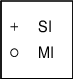

legend_dataset/Annotated_images/02162-10.1.1.331.9577-Figure-3.png
numero di linee attuale: 6
risultato originale predetto: 4.007665
numero di linee predetto dell'immagine: 4


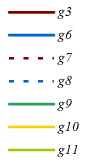

legend_dataset/Annotated_images/00191-10.1.1.150.8513-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/00404-10.1.1.352.6958-Figure-7.png
numero di linee attuale: 5
risultato originale predetto: 5.0256977
numero di linee predetto dell'immagine: 5


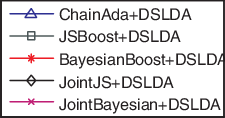

legend_dataset/Annotated_images/00120-10.1.1.43.5263-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.6490824
numero di linee predetto dell'immagine: 3


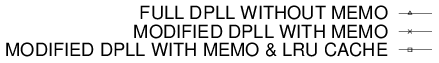

legend_dataset/Annotated_images/02058-10.1.1.50.958-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.8510258
numero di linee predetto dell'immagine: 3


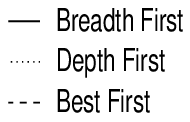

legend_dataset/Annotated_images/00792-10.1.1.19.9370-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.8211794
numero di linee predetto dell'immagine: 4


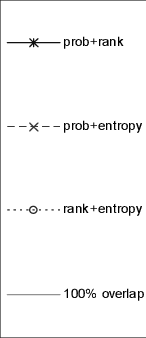

legend_dataset/Annotated_images/00965-10.1.1.135.2750-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 3.5783434
numero di linee predetto dell'immagine: 4


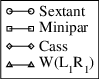

legend_dataset/Annotated_images/00468-10.1.1.332.8945-Figure-10.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


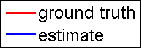

legend_dataset/Annotated_images/00328-10.1.1.385.5289-Figure-11.png
numero di linee attuale: 3
risultato originale predetto: 2.9548697
numero di linee predetto dell'immagine: 3


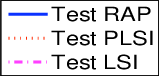

legend_dataset/Annotated_images/00503-10.1.1.139.2575-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 4.0140243
numero di linee predetto dell'immagine: 4


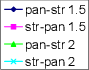

legend_dataset/Annotated_images/00938-10.1.1.182.9583-Figure-7.png
numero di linee attuale: 3
risultato originale predetto: 2.988725
numero di linee predetto dell'immagine: 3


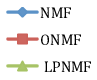

legend_dataset/Annotated_images/01698-10.1.1.329.7070-Figure-8.png
numero di linee attuale: 6
risultato originale predetto: 6.3037086
numero di linee predetto dell'immagine: 6


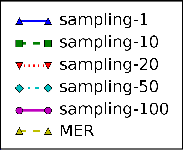

legend_dataset/Annotated_images/02115-10.1.1.363.3689-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/01071-10.1.1.421.2931-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


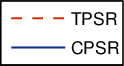

legend_dataset/Annotated_images/01082-10.1.1.138.5468-Figure-8.png
numero di linee attuale: 4
risultato originale predetto: 3.9239154
numero di linee predetto dell'immagine: 4


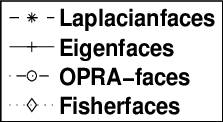

legend_dataset/Annotated_images/02857-10.1.1.331.8404-Figure-6.png
numero di linee attuale: 5
risultato originale predetto: 5.11692
numero di linee predetto dell'immagine: 5


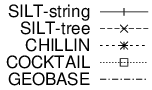

legend_dataset/Annotated_images/03152-10.1.1.105.8827-Figure-9.png
numero di linee attuale: 3
risultato originale predetto: 2.962888
numero di linee predetto dell'immagine: 3


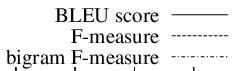

legend_dataset/Annotated_images/03130-10.1.1.421.8044-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 3.5170236
numero di linee predetto dell'immagine: 4


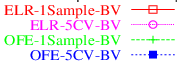

legend_dataset/Annotated_images/00942-10.1.1.324.2945-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


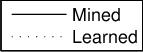

legend_dataset/Annotated_images/02536-10.1.1.385.5289-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 4.291131
numero di linee predetto dell'immagine: 4


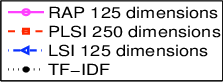

legend_dataset/Annotated_images/00154-10.1.1.152.9748-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


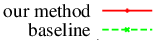

legend_dataset/Annotated_images/01566-10.1.1.208.2318-Figure-10.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


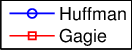

legend_dataset/Annotated_images/00524-10.1.1.231.837-Figure-8.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


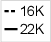

legend_dataset/Annotated_images/01748-10.1.1.422.6729-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.8527348
numero di linee predetto dell'immagine: 2


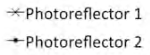

legend_dataset/Annotated_images/02435-10.1.1.148.6426-Figure-3.png
numero di linee attuale: 6
risultato originale predetto: 6.06766
numero di linee predetto dell'immagine: 6


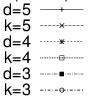

legend_dataset/Annotated_images/02517-10.1.1.302.7829-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.8258438
numero di linee predetto dell'immagine: 3


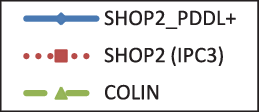

legend_dataset/Annotated_images/02510-10.1.1.4.5252-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


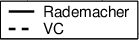

legend_dataset/Annotated_images/00175-10.1.1.153.3551-Figure-6.png
numero di linee attuale: 4
risultato originale predetto: 3.6110432
numero di linee predetto dell'immagine: 4


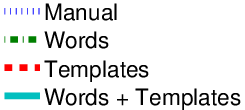

legend_dataset/Annotated_images/02223-10.1.1.101.7661-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 3.6854217
numero di linee predetto dell'immagine: 4


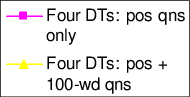

legend_dataset/Annotated_images/01408-10.1.1.384.8537-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 3.9362803
numero di linee predetto dell'immagine: 4


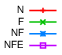

legend_dataset/Annotated_images/02928-10.1.1.297.5275-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


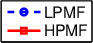

legend_dataset/Annotated_images/02617-10.1.1.149.4426-Figure-3.png
numero di linee attuale: 3
risultato originale predetto: 2.879971
numero di linee predetto dell'immagine: 3


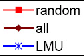

legend_dataset/Annotated_images/00765-10.1.1.306.7483-Figure-6.png
numero di linee attuale: 7
risultato originale predetto: 7.975306
numero di linee predetto dell'immagine: 8


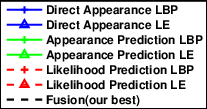

legend_dataset/Annotated_images/01469-10.1.1.348.4141-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


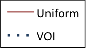

legend_dataset/Annotated_images/00295-10.1.1.366.9604-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/02990-10.1.1.217.6984-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.2670376
numero di linee predetto dell'immagine: 2


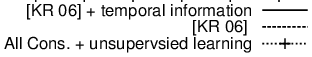

legend_dataset/Annotated_images/02962-10.1.1.412.3848-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


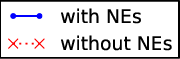

legend_dataset/Annotated_images/03073-10.1.1.157.5707-Figure-1.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


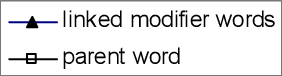

legend_dataset/Annotated_images/00881-10.1.1.228.2503-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 3.6264138
numero di linee predetto dell'immagine: 4


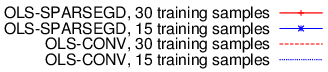

legend_dataset/Annotated_images/01544-10.1.1.170.923-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


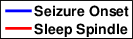

legend_dataset/Annotated_images/02395-10.1.1.159.1507-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.8974502
numero di linee predetto dell'immagine: 3


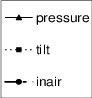

legend_dataset/Annotated_images/01900-10.1.1.331.4770-Figure-7.png
numero di linee attuale: 3
risultato originale predetto: 2.9476817
numero di linee predetto dell'immagine: 3


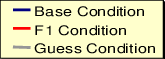

legend_dataset/Annotated_images/03322-10.1.1.402.8944-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.918752
numero di linee predetto dell'immagine: 3


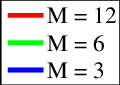

legend_dataset/Annotated_images/00202-10.1.1.353.8127-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 4.1823597
numero di linee predetto dell'immagine: 4


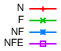

legend_dataset/Annotated_images/01854-10.1.1.112.4085-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


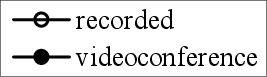

legend_dataset/Annotated_images/02062-10.1.1.153.4833-Figure-7.png
numero di linee attuale: 4
risultato originale predetto: 4.3752413
numero di linee predetto dell'immagine: 4


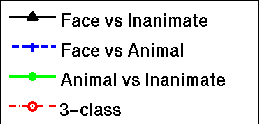

legend_dataset/Annotated_images/02933-10.1.1.53.8203-Figure-5.png
numero di linee attuale: 3
risultato originale predetto: 3.3734584
numero di linee predetto dell'immagine: 3


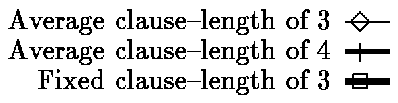

legend_dataset/Annotated_images/01695-10.1.1.5.2657-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


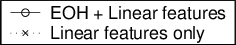

legend_dataset/Annotated_images/01195-10.1.1.161.1193-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 3.7674031
numero di linee predetto dell'immagine: 4


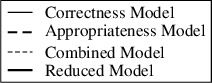

legend_dataset/Annotated_images/03274-10.1.1.386.6705-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.8480747
numero di linee predetto dell'immagine: 3


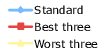

legend_dataset/Annotated_images/01202-10.1.1.148.6144-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.923048
numero di linee predetto dell'immagine: 3


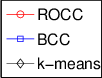

legend_dataset/Annotated_images/01855-10.1.1.207.5424-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.6399605
numero di linee predetto dell'immagine: 4


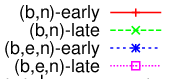

legend_dataset/Annotated_images/01317-10.1.1.419.361-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


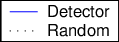

legend_dataset/Annotated_images/02042-10.1.1.149.6166-Figure-2.png
numero di linee attuale: 6
risultato originale predetto: 5.2612042
numero di linee predetto dell'immagine: 5


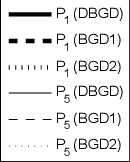

legend_dataset/Annotated_images/02718-10.1.1.308.1929-Figure-7.png
numero di linee attuale: 5
risultato originale predetto: 5.0804424
numero di linee predetto dell'immagine: 5


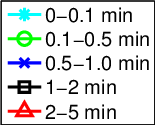

legend_dataset/Annotated_images/02243-10.1.1.138.5468-Figure-6.png
numero di linee attuale: 4
risultato originale predetto: 4.489953
numero di linee predetto dell'immagine: 4


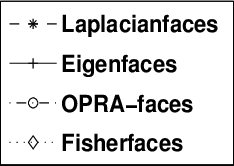

legend_dataset/Annotated_images/00919-10.1.1.136.6850-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 1.9373972
numero di linee predetto dell'immagine: 2


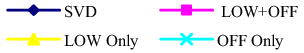

legend_dataset/Annotated_images/00980-10.1.1.43.7008-Figure-14.png
numero di linee attuale: 4
risultato originale predetto: 3.8224368
numero di linee predetto dell'immagine: 4


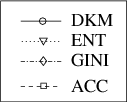

legend_dataset/Annotated_images/02698-10.1.1.154.5788-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 2.169847
numero di linee predetto dell'immagine: 2


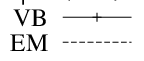

legend_dataset/Annotated_images/01022-10.1.1.420.8551-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


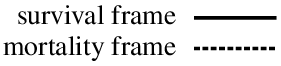

legend_dataset/Annotated_images/01800-10.1.1.43.8138-Figure-8.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


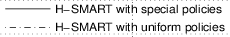

legend_dataset/Annotated_images/00398-10.1.1.164.3678-Figure-11.png
numero di linee attuale: 7
risultato originale predetto: 8.044762
numero di linee predetto dell'immagine: 8


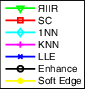

legend_dataset/Annotated_images/00397-10.1.1.165.7670-Figure-8.png
numero di linee attuale: 5
risultato originale predetto: 5.2689047
numero di linee predetto dell'immagine: 5


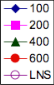

legend_dataset/Annotated_images/01130-10.1.1.149.9543-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


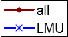

legend_dataset/Annotated_images/02378-10.1.1.294.5591-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 4.044428
numero di linee predetto dell'immagine: 4


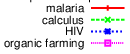

legend_dataset/Annotated_images/00211-10.1.1.165.9484-Figure-1.png
numero di linee attuale: 3
risultato originale predetto: 2.7975304
numero di linee predetto dell'immagine: 3


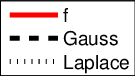

legend_dataset/Annotated_images/01132-10.1.1.408.1792-Figure-10.png
numero di linee attuale: 4
risultato originale predetto: 3.5677516
numero di linee predetto dell'immagine: 4


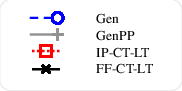

legend_dataset/Annotated_images/00659-10.1.1.218.7782-Figure-1.png
numero di linee attuale: 6
risultato originale predetto: 6.6760616
numero di linee predetto dell'immagine: 7


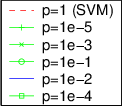

legend_dataset/Annotated_images/03160-10.1.1.160.5630-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.8550596
numero di linee predetto dell'immagine: 4


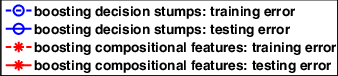

legend_dataset/Annotated_images/02080-10.1.1.160.3397-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


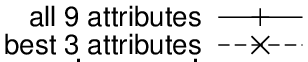

legend_dataset/Annotated_images/02114-10.1.1.192.9439-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


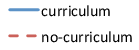

legend_dataset/Annotated_images/01827-10.1.1.380.3640-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 3.5809593
numero di linee predetto dell'immagine: 4


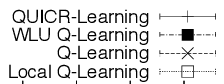

legend_dataset/Annotated_images/02156-10.1.1.225.6901-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


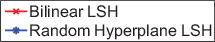

legend_dataset/Annotated_images/00172-10.1.1.331.5335-Figure-6.png
numero di linee attuale: 3
risultato originale predetto: 2.8060544
numero di linee predetto dell'immagine: 3


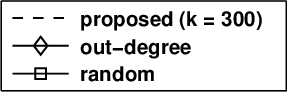

legend_dataset/Annotated_images/00408-10.1.1.143.6345-Figure-8.png
numero di linee attuale: 5
risultato originale predetto: 5.9152937
numero di linee predetto dell'immagine: 6


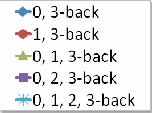

legend_dataset/Annotated_images/02619-10.1.1.30.269-Figure-9.png
numero di linee attuale: 3
risultato originale predetto: 2.9118237
numero di linee predetto dell'immagine: 3


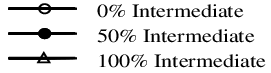

legend_dataset/Annotated_images/00652-10.1.1.164.1174-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


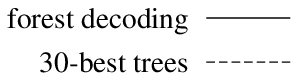

legend_dataset/Annotated_images/02212-10.1.1.408.715-Figure-3.png
numero di linee attuale: 3
risultato originale predetto: 2.9931164
numero di linee predetto dell'immagine: 3


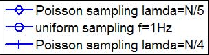

legend_dataset/Annotated_images/01206-10.1.1.170.1063-Figure-5.png
numero di linee attuale: 3
risultato originale predetto: 3.0765648
numero di linee predetto dell'immagine: 3


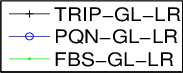

legend_dataset/Annotated_images/01471-10.1.1.331.282-Figure-7.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


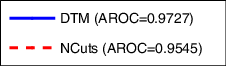

legend_dataset/Annotated_images/02086-10.1.1.386.6332-Figure-6.png
numero di linee attuale: 2
risultato originale predetto: 2.5144854
numero di linee predetto dell'immagine: 3


legend_dataset/Annotated_images/01580-10.1.1.206.5167-Figure-4.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


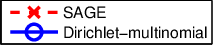

legend_dataset/Annotated_images/01636-10.1.1.186.3498-Figure-13.png
numero di linee attuale: 5
risultato originale predetto: 5.313769
numero di linee predetto dell'immagine: 5


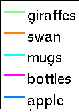

legend_dataset/Annotated_images/00128-10.1.1.278.7060-Figure-5.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


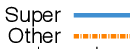

legend_dataset/Annotated_images/02391-10.1.1.192.2616-Figure-2.png
numero di linee attuale: 5
risultato originale predetto: 3.8989692
numero di linee predetto dell'immagine: 4


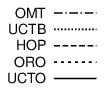

legend_dataset/Annotated_images/00734-10.1.1.34.1849-Figure-2.png
numero di linee attuale: 4
risultato originale predetto: 2.9922228
numero di linee predetto dell'immagine: 3


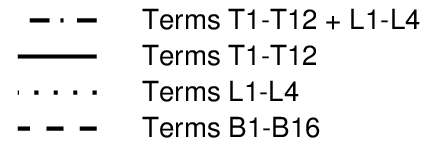

legend_dataset/Annotated_images/01416-10.1.1.2.92-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


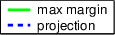

legend_dataset/Annotated_images/02125-10.1.1.174.8234-Figure-6.png
numero di linee attuale: 3
risultato originale predetto: 2.811924
numero di linee predetto dell'immagine: 3


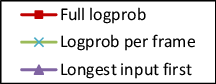

legend_dataset/Annotated_images/00912-10.1.1.208.2318-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 4.1466475
numero di linee predetto dell'immagine: 4


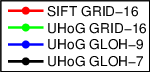

legend_dataset/Annotated_images/03320-10.1.1.164.2102-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 1.9725057
numero di linee predetto dell'immagine: 2


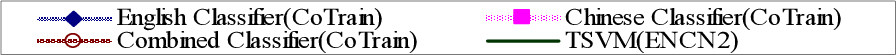

legend_dataset/Annotated_images/01087-10.1.1.143.4579-Figure-9.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


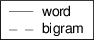

legend_dataset/Annotated_images/03288-10.1.1.419.1033-Figure-5.png
numero di linee attuale: 3
risultato originale predetto: 2.9694734
numero di linee predetto dell'immagine: 3


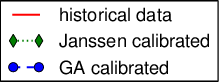

legend_dataset/Annotated_images/00084-10.1.1.174.9242-Figure-3.png
numero di linee attuale: 3
risultato originale predetto: 3.2267144
numero di linee predetto dell'immagine: 3


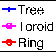

legend_dataset/Annotated_images/00080-10.1.1.219.5171-Figure-6.png
numero di linee attuale: 8
risultato originale predetto: 7.707524
numero di linee predetto dell'immagine: 8


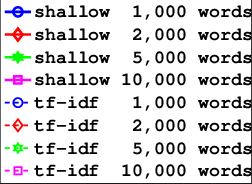

legend_dataset/Annotated_images/02448-10.1.1.386.9989-Figure-8.png
numero di linee attuale: 8
risultato originale predetto: 5.9166985
numero di linee predetto dell'immagine: 6


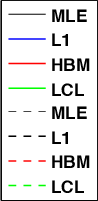

legend_dataset/Annotated_images/01491-10.1.1.42.6672-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.9013665
numero di linee predetto dell'immagine: 3


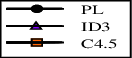

legend_dataset/Annotated_images/01861-10.1.1.219.5171-Figure-5.png
numero di linee attuale: 9
risultato originale predetto: 6.7274647
numero di linee predetto dell'immagine: 7


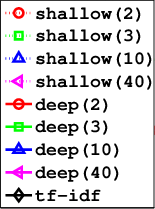

legend_dataset/Annotated_images/01463-10.1.1.16.4936-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 2.7401824
numero di linee predetto dell'immagine: 3


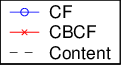

legend_dataset/Annotated_images/00293-10.1.1.323.9133-Figure-14.png
numero di linee attuale: 2
risultato originale predetto: 2.2799017
numero di linee predetto dell'immagine: 2


legend_dataset/Annotated_images/00203-10.1.1.18.7410-Figure-5.png
numero di linee attuale: 4
risultato originale predetto: 3.6216888
numero di linee predetto dell'immagine: 4


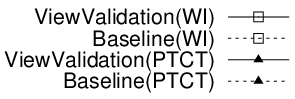

legend_dataset/Annotated_images/01342-10.1.1.378.7544-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 3.0951214
numero di linee predetto dell'immagine: 3


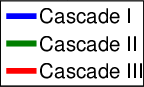

legend_dataset/Annotated_images/00789-10.1.1.360.8064-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 4.6064897
numero di linee predetto dell'immagine: 5


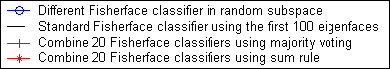

legend_dataset/Annotated_images/00220-10.1.1.4.9606-Figure-7.png
numero di linee attuale: 3
risultato originale predetto: 2.6394548
numero di linee predetto dell'immagine: 3


legend_dataset/Annotated_images/00979-10.1.1.169.3772-Figure-4.png
numero di linee attuale: 4
risultato originale predetto: 4.421925
numero di linee predetto dell'immagine: 4


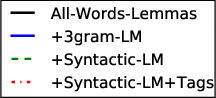

legend_dataset/Annotated_images/02868-10.1.1.128.648-Figure-1.png
numero di linee attuale: 3
risultato originale predetto: 2.8423235
numero di linee predetto dell'immagine: 3


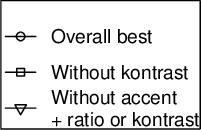

legend_dataset/Annotated_images/01540-10.1.1.368.1401-Figure-4.png
numero di linee attuale: 3
risultato originale predetto: 2.9576397
numero di linee predetto dell'immagine: 3


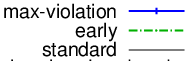

legend_dataset/Annotated_images/00804-10.1.1.157.559-Figure-4.png
numero di linee attuale: 6
risultato originale predetto: 6.3689275
numero di linee predetto dell'immagine: 6


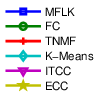

legend_dataset/Annotated_images/00780-10.1.1.124.5204-Figure-5.png
numero di linee attuale: 3
risultato originale predetto: 2.9995866
numero di linee predetto dell'immagine: 3


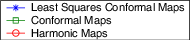

legend_dataset/Annotated_images/01073-10.1.1.163.1109-Figure-7.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


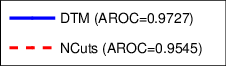

legend_dataset/Annotated_images/02338-10.1.1.17.7460-Figure-3.png
numero di linee attuale: 7
risultato originale predetto: 3.8246913
numero di linee predetto dell'immagine: 4


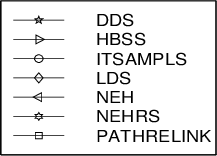

legend_dataset/Annotated_images/00020-10.1.1.2.2236-Figure-3.png
numero di linee attuale: 4
risultato originale predetto: 3.8415008
numero di linee predetto dell'immagine: 4


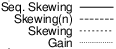

legend_dataset/Annotated_images/00138-10.1.1.374.4400-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


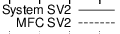

legend_dataset/Annotated_images/01683-10.1.1.128.9917-Figure-3.png
numero di linee attuale: 2
risultato originale predetto: 1.8759207
numero di linee predetto dell'immagine: 2


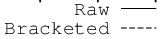

legend_dataset/Annotated_images/01735-10.1.1.164.5853-Figure-2.png
numero di linee attuale: 3
risultato originale predetto: 3.035612
numero di linee predetto dell'immagine: 3


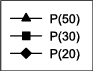

legend_dataset/Annotated_images/01554-10.1.1.298.8002-Figure-2.png
numero di linee attuale: 2
risultato originale predetto: 1.999874
numero di linee predetto dell'immagine: 2


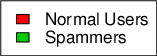

In [ ]:
# import the necessary packages
# import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
# import tensorflow_addons as tfa
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os
from google.colab.patches import cv2_imshow

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
#                 help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# # determine the input file type, but assume that we're working with
# # single input image
# filetype = mimetypes.guess_type(args["input"])[0]
# imagePaths = [args["input"]]
# if the file type is a text file, then we need to process *multiple*
# images

switch = input("predire su training (1) o su validation (2)?: ")
if switch == str(1):
    args = 'output/train_images.txt'
else:
    args = 'output/test_images.txt'

filetype = 'text/plain'
imagePaths = [args]
annotsPaths = []

if "text/plain" == filetype:
    # load the filenames in our testing file and initialize our list
    # of image paths
    filenames = open(args).read().strip().split("\n")
    imagePaths = []
    # loop over the filenames
    for f in filenames:
        for row in rows:
            row = row.split(",")
            if f == row[0]:
                annotsPaths.append(row[1:])
        # construct the full path to the image filename and then
        # update our image paths list
        p = os.path.sep.join([IMAGES_PATH, f])
        imagePaths.append(p)

# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH, compile=False)
# loop over the images that we'll be testing using our bounding box
# regression model
i = 0
while i < int(len(imagePaths)):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    print(imagePaths[i])
    image = load_img(imagePaths[i], target_size=(MIN_HEIGHT, MIN_WIDTH))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    num_lines_pred = model.predict(image)

    # (startX, startY, endX, endY) = preds[0]
    # (a_startX, a_startY, a_endX, a_endY) = axis_preds[0]

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePaths[i])
    # image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions

    if annotsPaths:
        annots = []
        for annot in annotsPaths[i]:
            annots.append(int(annot))
        (gt_l_startX, gt_l_startY, gt_l_endX, gt_l_endY, gt_a_startX, gt_a_startY, gt_a_endX, gt_a_endY, gt_num_lines) = annots

        print('numero di linee attuale: ' + str(gt_num_lines))
        # print('Bbox della legenda attuale: ' + str(gt_l_startX), str(gt_l_startY), str(gt_l_endX), str(gt_l_endY))

        # print('Bbox degli assi attuale: ' + str(gt_a_endX), str(gt_a_endY), str(gt_a_startX), str(gt_a_startY))
        # # draw the predicted bounding box on the image
        # cv2.rectangle(image, (gt_l_startX, gt_l_startY), (gt_l_endX, gt_l_endY), (0, 255, 0), 2)
        # cv2.rectangle(image, (gt_a_endX, gt_a_endY), (gt_a_startX, gt_a_startY), (0, 255, 0), 2)

    print("risultato originale predetto: " + str(num_lines_pred[0][0]))
    # num_lines = np.argmax(num_lines_pred[0]) + 1
    print("numero di linee predetto dell'immagine: " + str(round(num_lines_pred[0][0])))

    # startX = int(startX * w)
    # startY = int(startY * h)
    # endX = int(endX * w)
    # endY = int(endY * h)
    # print('Bbox della legenda predetta: ' + str(startX), str(startY), str(endX), str(endY))
    # a_startX = int(a_startX * w)
    # a_startY = int(a_startY * h)
    # a_endX = int(a_endX * w)
    # a_endY = int(a_endY * h)
    # print('Bbox degli assi predetta: ' + str(a_endX), str(a_endY), str(a_startX), str(a_startY))
    # # draw the predicted bounding box on the image
    # cv2.rectangle(image, (startX, startY), (endX, endY),
    #               (255, 0, 0), 2)
    # cv2.rectangle(image, (a_endX, a_endY), (a_startX, a_startY),
    #               (0, 0, 255), 2)
    # show the output image
    cv2_imshow(image)
    k = cv2.waitKeyEx(0)

    if k == 27:  # close on ESC key
        break
    if k == 2424832:  # get back on left arrow key
        i = i - 1
    else:
        i += 1


In [ ]:
!zip -r output.zip output/

  adding: output/ (stored 0%)
  adding: output/detector.h5 (deflated 24%)
  adding: output/model.png (deflated 17%)
  adding: output/Plots/ (stored 0%)
  adding: output/Plots/total_loss.png (deflated 5%)
  adding: output/test_images.txt (deflated 74%)
  adding: output/train_images.txt (deflated 75%)
